In [1]:
import tensorflow as tf
import os 
import numpy as np
import numpy.random as rng
from tensorflow.examples.tutorials.mnist import input_data
from rbm.examples import bas_data 
from rbm.helper import batch 
from rbm.model import rbm 
import matplotlib.pyplot as plt
import time 

mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
mnist_train = mnist.train

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Create session.
sess = tf.InteractiveSession()

# Initialize RBM Model for MNIST reconstruction
rbm_model= rbm.RBM(n_visible = 784, n_hidden = 64, lr = tf.constant(0.1,tf.float32), epochs = 2000)

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None,rbm_model.n_visible], name="visible_layer")
size = tf.cast(tf.shape(v)[0], tf.float32)

# Initialize weights and biases a la Hinton
with tf.name_scope('Weights'):
    W = tf.Variable(tf.random_normal([rbm_model.n_visible, rbm_model.n_hidden], mean=0., stddev=4 * np.sqrt(6. / (rbm_model.n_visible + rbm_model.n_hidden))), name="weights")
    tf.summary.histogram('weights',W)
    
vb = tf.Variable(tf.zeros([1,rbm_model.n_visible]),tf.float32, name="visible_bias")
hb = tf.Variable(tf.zeros([1,rbm_model.n_hidden]),tf.float32, name="hidden_bias")

# Similarity between reconstructed/sampled visible layer and input during training. 
# Summary for Tensorboard visualization 
with tf.name_scope("Reconstruction_error"): 
    reconstruction_error = tf.Variable(0.0,name="reconstruction_error")
    tf.summary.scalar('reconstruction_error',reconstruction_error)


# Contrastive divergence after 1 sampling step. 
Positive divergence: $\mathbf{v_0^T \times p(h_0|v_0)}$  
Sample hidden states from: $\mathbf{h_0 \sim p(h_0|v_0)}$.  
Reconstruct visible units: $\mathbf{v_s \sim p(v_{s})=p(v_1|h_0)}$  
Negative divergence: $\mathbf{p(v_{s})^T \times p(h_1|v_s)}$


In [4]:
# K-step Contrastive Divergence using Gibbs sampling
# Positive divergence    
with tf.name_scope('Hidden_probabilities'):
    pos_hid_prob = rbm.get_probabilities('hidden',W,v,hb)
with tf.name_scope('Positive_Divergence'):
    pos_divergence = tf.matmul(tf.transpose(v),pos_hid_prob)

pos_hid_states = rbm.sample(pos_hid_prob)
neg_vis_prob = rbm.get_probabilities('visible', W, pos_hid_states, vb)
#neg_vis_states = rbm.sample(neg_vis_prob)

# Negative divergence
with tf.name_scope('Negative_hidden_probabilities'):
    neg_hid_prob = rbm.get_probabilities('hidden', W, neg_vis_prob, hb)
with tf.name_scope('Negative_Divergence'):
    neg_divergence = tf.matmul(tf.transpose(neg_vis_prob),neg_hid_prob)
    
    
# Accuracy on reconstructing visible layer and free energy
a = tf.reduce_mean(tf.squared_difference(v,neg_vis_prob))
rec_error = [reconstruction_error.assign(a)]
#energy  =  rbm.free_energy(v = v, weights=W,hbias=hb,vbias=vb) 
#accuracy_update = [accuracy.assign_add(reconstruction_accuracy)]

# Update rules for weights and biases.  
$w_{new} = w_{old} + \epsilon *$ (positive divergence - negative divergence)  
$vb_{new} = vb_{old} + \epsilon * (v_0 - p(v_s))$  
$vb_{new} = vb_{old} + \epsilon * (p(h_0) - p(h_1))$

In [5]:
# Update rules for weights and biases
# Summaries of gradient for Tensorboard visualization
with tf.name_scope('Weight_gradient'):
    delta_w = tf.multiply(rbm_model.lr/size, tf.subtract(pos_divergence,neg_divergence))
    weight_gradient_scalar = tf.summary.scalar('weight_increment',tf.reduce_mean(delta_w))
with tf.name_scope('Visible_bias_gradient'):
    delta_vb = tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(v,neg_vis_prob), 0, keep_dims=True))
with tf.name_scope('Hidden_bias_gradient'):
    delta_hb= tf.multiply(rbm_model.lr/size, tf.reduce_sum(tf.subtract(pos_hid_prob,neg_hid_prob), 0, keep_dims=True))

update = [W.assign_add(delta_w), vb.assign_add(delta_vb), hb.assign_add(delta_hb)] 
# Debug mode
#Weight increment changes as seen by plotting delta_w for the entire dataset
#error_sum = [error.assign_add(delta_w)]
#total_err = tf.reduce_mean(error)
#reinit = error.assign(tf.zeros([rbm_model.n_visible,rbm_model.n_hidden]))

# Merge summaries for Tensorboard
summary = tf.summary.merge_all()
path_test = os.getcwd()  + '/RBM_logs/MNIST_Bernoulli'
test_writer = tf.summary.FileWriter(path_test,sess.graph)

sess.run(tf.global_variables_initializer())


# Stochastic gradient descent with batch size of 10. Test every 500 iterations

In [6]:
start_time = time.time()
##### Start of training ######
##### -----------------#######
for epoch in range(rbm_model.epochs):
    #if epoch % 30 == 0: 
        #sess.run(reinit)
    if epoch % 500 == 0:
        feed={v: mnist.test.images}
        result = sess.run([rec_error,summary],feed_dict=feed)
        acc = result[0]
        test_writer.add_summary(result[1],epoch)
        print("Reconstruction error at step %s: %s" % (epoch, acc))
        #err[epoch] = sess.run(total_err)
        #print("Absolute gradient estimate of log-likelihood on epoch %s is %s" %(epoch,np.abs(err[epoch])))
    else: 
        batchXs, batchYs = mnist.train.next_batch(10)
        feed={v: batchXs}
        result = sess.run([update], feed_dict = feed)
        # Print log-likelihood to visualize how it decreases 
    
##### --------------- ######        
##### End of Training ######

# Plot
print("Elapsed time for training Bernoulli RBM with CD-1 and %s epochs: %s "%(rbm_model.epochs,time.time()-start_time))
#rbm.plot_weight_update(x=np.arange(0,rbm_model.epochs,1),y=np.abs(err))

Reconstruction error at step 0: [0.32361457]
Reconstruction error at step 500: [0.033370089]
Reconstruction error at step 1000: [0.029277116]
Reconstruction error at step 1500: [0.027188025]
Elapsed time for training Bernoulli RBM with CD-1 and 2000 epochs: 4.404980897903442 


## Reconstruct some digits using Gibbs sampling

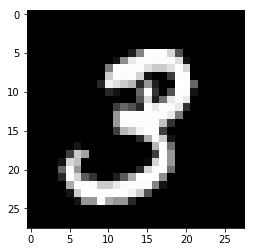

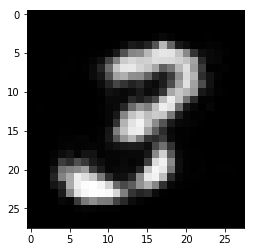

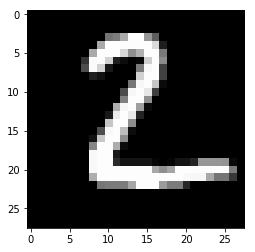

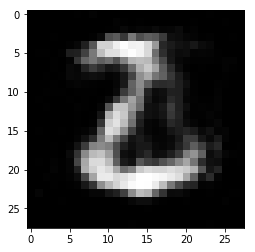

In [7]:
##### Testing ##### 
# Testing the RBM for one sample step after learning the weights        
first_image = 1
test_image = mnist_train.images[first_image]
test_image2 = mnist.test.images[first_image]
def show_digit(x):
    plt.imshow(x.reshape((28,28)),cmap = plt.cm.gray)
    plt.show()

sample = rbm.gibbs(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
sample_test = rbm.gibbs(1,v=v,hb=hb,vb=vb,W=W).eval(session=sess, feed_dict={v: test_image2.reshape(1,-1).astype(np.float32)})    
show_digit(test_image)
show_digit(sample)

show_digit(test_image2)
show_digit(sample_test)
tf.reset_default_graph()